## Filling Temporal Gaps within and between GRACE and GRACE-FO Terrestrial Water Storage Changes using Deep Learning Techniques.

This notebook contains the python code used to fill the 33 months temporal gaps in the GRACE/GRACE-FO satellite mission. Various sections of the notebook provides an overview of the steps taken to reconstruct the GRACE time series.

1. Pre-processing: In this section, various input datasets have been first reprojected, clipped for the study region. 
2. Deep Learning training: This section deals with the actual deep learning training. We are using Keras tuner to tune the hyper-parameters of the deep learning model (CNN-LSTM in our case).
3. Results compilation: In this section, results are compiled and plotted. The reconstructed GRACE-TWS is also saved as NETCDF. 

In [1]:
#Imports:
import NetcdfFormatter as nc
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
import os
import multiprocessing as mp
import matplotlib.pyplot as plt
nc = nc.NetcdfFormatter()

## Section 1: Pre-processing

To pre-process the data, different steps are taken:
1. Reprojection different resolution datasets to same resolution.
2. Clipping the datasets using shapefile
3. Converting netcdf to grid-wise datasets

In [ ]:
def reproject(file):
    nc.reproject_nc(path=file, algorithm='con2', remap_grid='./data/original/grace_jpl_mascon.nc', save_loc='./data/reproj/')

def clip(file):
    nc.clip_region(path=file, shp_f='./IND/IND_adm0.shp', save_loc='./data/clipped/')

if __name__ == '__main__':
    original_f = glob.glob(os.path.join('./data/original/*.nc'))
    clipped_f = glob.glob(os.path.join('./data/clipped/*.nc'))

    pool = mp.Pool(processes=mp.cpu_count())  # Use all available CPU cores

    print("Reprojecting datasets...")
    pool.map(reproject, original_f)
    pool.close()
    pool.join()

    print("Clipping datasets...")
    pool.map(clip, clipped_f)
    pool.close()
    pool.join()

    print("All datasets reprojected and clipped.")

In [7]:
# Loading datasets from different satellites using netcdf:
grace_jpl = xr.open_dataset('./data/reproj/grace_jpl_05.nc')
grace_jpl_df = grace_jpl.to_dataframe().dropna().reset_index()
grace_jpl_index = grace_jpl_df[['lat', 'lon']].drop_duplicates().values

# GRACE mascons solutions from different datasets:
grace_jpl = xr.open_dataset('./data/reproj/grace_jpl_05.nc')
grace_csr = xr.open_dataset('./data/reproj/grace_csr_05.nc').sel(time = slice(None, '2022-08-01'))
grace_gsfz = xr.open_dataset('./data/reproj/grace_gsfz_05.nc')
#Other variables import:
gldas_noah = xr.open_dataset('./data/reproj/gldas_05.nc')                         # GLDAS 
era_temp = xr.open_dataset('./data/reproj/Temperature_era_05.nc')                 # Temperature
modis_ndvi = xr.open_dataset('./data/reproj/MODIS_NDVI_05.nc')                    # MODIS NDVI
chirps_rain = xr.open_dataset('./data/reproj/chirps_05.nc')                       # CHIRPS Rainfall

/home/pragay/.local/lib/python3.10/site-packages/xarray/coding/times.py:242: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/pragay/.local/lib/python3.10/site-packages/xarray/coding/times.py:242: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/pragay/.local/lib/python3.10/site-packages/xarray/coding/times.py:242: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/pragay/.local/lib/python3.10/site-packages/xarray/coding/times.py:242: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/pragay/.local/lib/python3.10/site-packages/xarray/coding/times.py:242: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_P

In [ ]:
#Compilation of datasets:
def anomalies(variable):
    return variable-np.mean(np.abs((variable.sel(time=slice("2004-01-01", "2009-12-01")).values)))

def data_prep(i):
    time_section = slice("2001-01-01", "2022-07-01")
    #GRACE:
    lwe_jpl = grace_jpl['lwe_thickness'].sel(lat=i[0], lon=i[1] ,time=time_section).resample(time="1MS").mean() #JPL solutions
    lwe_csr = grace_csr['lwe_thickness'].sel(lat=i[0], lon=i[1] ,time=time_section).resample(time="1MS").mean() #CSR solutions
    lwe_gsfz = grace_gsfz['lwe_thickness'].sel(lat=i[0], lon=i[1] ,time=time_section).resample(time="1MS").mean() # gsfz solutions
    average = (lwe_jpl+lwe_csr+lwe_gsfz)/3
    #Other variables:
    ndvi = anomalies((modis_ndvi['NDVI'].sel(lat=i[0], lon=i[1] ,time=time_section).resample(time="1MS").mean())*0.0001) #NDVI Please note that 0.0001 is the scaling factor provided in Google earth engine.
    temp = anomalies(era_temp['skt'].sel(lat=i[0], lon=i[1] ,time=time_section).sel(expver = 1).resample(time="1MS").mean()) #Skin temperature
    precp = anomalies(chirps_rain['precip'].sel(lat=i[0], lon=i[1] ,time=time_section).resample(time="1MS").mean()) #Rainfall
    #GLDAS variables:
    et = anomalies(gldas_noah['Evap_tavg'].sel(lat=i[0], lon=i[1] ,time=time_section).resample(time="1MS").mean()) #Evapotranspiration
    cws = anomalies(gldas_noah['CanopInt_inst'].sel(lat=i[0], lon=i[1] ,time=time_section).resample(time="1MS").mean()) #Plant canopy 
    runoff = anomalies(gldas_noah['Qs_acc'].sel(lat=i[0], lon=i[1] ,time=time_section).resample(time="1MS").mean()) #Surface runoff
    swe = anomalies(gldas_noah['SWE_inst'].sel(lat=i[0], lon=i[1] ,time=time_section).resample(time="1MS").mean())
    soil_0_10 = anomalies(gldas_noah['SoilMoi0_10cm_inst'].sel(lat=i[0], lon=i[1] ,time=time_section).resample(time="1MS").mean())
    soil_10_40 = anomalies(gldas_noah['SoilMoi10_40cm_inst'].sel(lat=i[0], lon=i[1] ,time=time_section).resample(time="1MS").mean())
    soil_40_100 = anomalies(gldas_noah['SoilMoi40_100cm_inst'].sel(lat=i[0], lon=i[1] ,time=time_section).resample(time="1MS").mean())
    soil_100_200 = anomalies(gldas_noah['SoilMoi100_200cm_inst'].sel(lat=i[0], lon=i[1] ,time=time_section).resample(time="1MS").mean())
    tem_o = pd.DataFrame(list(zip(ndvi.values,
                               temp.values,
                               precp.values,
                               et.values,
                               cws.values,
                               runoff.values,
                               soil_0_10.values,
                               soil_10_40.values,
                               soil_40_100.values,
                               soil_100_200.values,
                               swe.values)), 
                               columns=['NDVI',
                                        'Temperature',
                                        'Precipitation',
                                        'Evapotranspiration',
                                        'Canopy water',
                                        'Runoff',
                                        'SoilM_0_10',
                                        'SoilM_10_40',
                                        'SoilM_40_100',
                                        'SoilM_100_200',
                                        'Snow water equivalent'],
                               index=temp['time'])
    tem_o.index.name = 'Date'
    tem_grace = pd.DataFrame(average.values, columns=['GRACE'], index = lwe_csr['time'])
    
    tem_grace.index.name = 'Date'
    df = tem_o.merge(tem_grace, how='left', left_index=True, right_index=True)
    df.to_csv('./data/COMPILED/{}_{}.csv'.format(i[0], i[1]))

if __name__ == '__main__':
    pool = mp.Pool()
    pool.map(data_prep, grace_jpl_index)

## Section 2: Deep Learning training

In this section, Deep Learning model is trained. We will be training gridwise and hyperparameters will also be tuned gridwise. After datasets are reprojected and clipped for the study region, X and y was created for each lat_lon grid. The main.py file directly uses the datasets from /data/COMPILED. and save models in Models file. Gridwise time series is saved in folder TIME SERIES and evaluation results for training and validation us saved in RESULTS Folder.

In [5]:
%run main.py

## Section 3: Compiling results as NETCDF:

In [2]:
df = pd.read_csv('./data/COMPILED/10.25_76.25.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

In [5]:
df_pred = pd.read_csv('./TIME SERIES/10.25_76.25.csv')
df_pred['Date'] = pd.to_datetime(df_pred['Date'])
df_pred.set_index('Date', inplace = True)

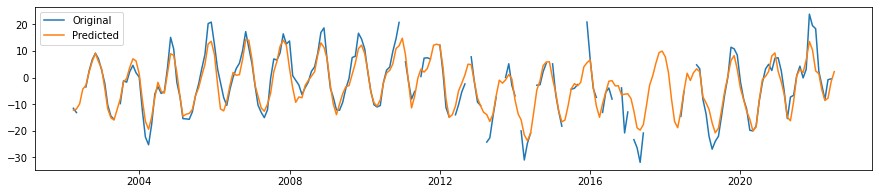

In [7]:
plt.figure(figsize=(15,3))
plt.plot(df['GRACE'])
plt.plot(df_pred['GRACE-Predicted'])
plt.legend(['Original', 'Predicted'])
plt.show()

In [11]:
#Training:
trn = glob.glob(os.path.join('./Train/*.csv'))
tes = glob.glob(os.path.join('./Test/*.csv'))

ds_train = pd.DataFrame(pd.read_csv(trn[0]))
for i in trn[1:]:
    ds_train = pd.concat([ds_train, pd.read_csv(i)], axis = 0)
ds_train.set_index(['lat', 'lon'], inplace = True) 
ds_train.to_csv('./Results/Training.csv')
# Testing:
ds_test = pd.DataFrame(pd.read_csv(trn[0]))
for i in tes[1:]:
    ds_test = pd.concat([ds_test, pd.read_csv(i)], axis = 0)
ds_test.set_index(['lat', 'lon'], inplace = True) 
ds_test.to_csv('./Results/Testing.csv')

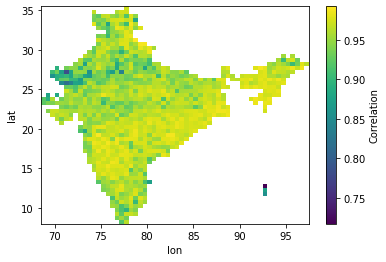

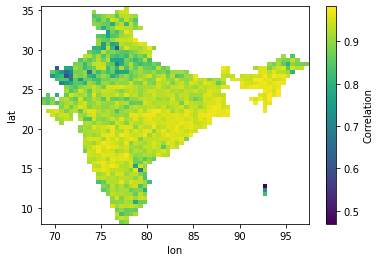

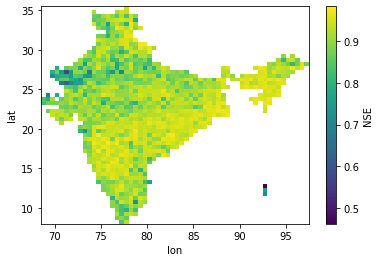

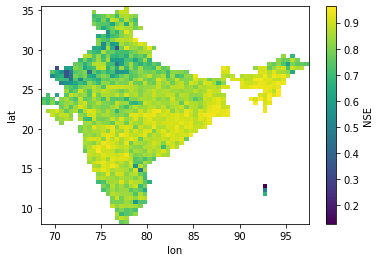

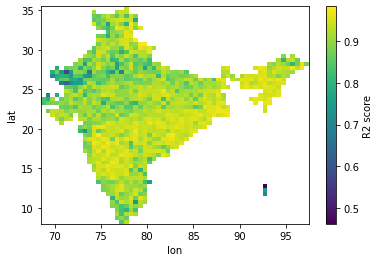

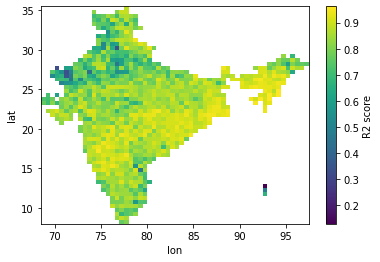

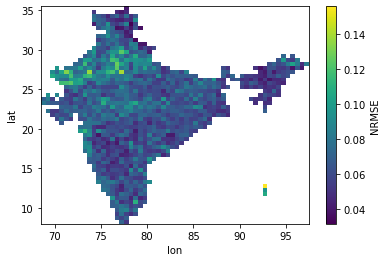

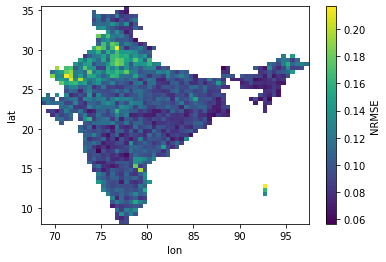

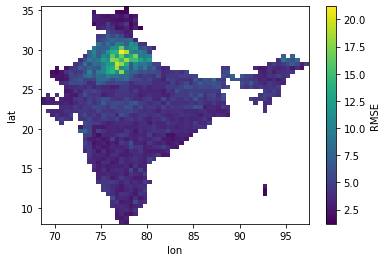

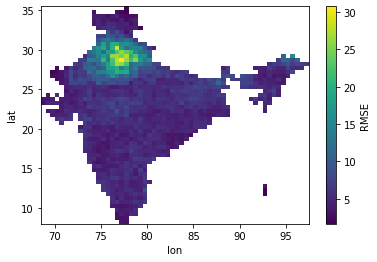

In [74]:
#Training:
ds_train = pd.read_csv('./Results/Training.csv')
ds_train.set_index(['lon', 'lat'], inplace=True)
ds_train = ds_train.to_xarray()
ds_train = ds_train.transpose()
#Testing
ds_test = pd.read_csv('./Results/Testing.csv')
ds_test.set_index(['lon', 'lat'], inplace=True)
ds_test = ds_test.to_xarray()
ds_test = ds_test.transpose()

#Plot:
xr.plot.pcolormesh(ds_train['Correlation'][:, :], cmap='viridis')
# plt.savefig('Correlation Train.png', dpi=600)
plt.show()

xr.plot.pcolormesh(ds_test['Correlation'][:, :], cmap='viridis')
# plt.savefig('Correlation Test.png', dpi=600)
plt.show()

xr.plot.pcolormesh(ds_train['NSE'][:, :], cmap='viridis')
# plt.savefig('NSE Train.png', dpi=600)
plt.show()

xr.plot.pcolormesh(ds_test['NSE'][:, :], cmap='viridis')
# plt.savefig('NSE Test.png', dpi=600)
plt.show()

xr.plot.pcolormesh(ds_train['R2 score'][:, :], cmap='viridis')
# plt.savefig('R2 score Train.png', dpi=600)
plt.show()

xr.plot.pcolormesh(ds_test['R2 score'][:, :], cmap='viridis')
# plt.savefig('R2 score Test.png', dpi=600)
plt.show()

xr.plot.pcolormesh(ds_train['NRMSE'][:, :], cmap='viridis')
# plt.savefig('NRMSE Train.png', dpi=600)
plt.show()

xr.plot.pcolormesh(ds_test['NRMSE'][:, :], cmap='viridis')
# plt.savefig('NRMSE Test.png', dpi=600)
plt.show()

xr.plot.pcolormesh(ds_train['RMSE'][:, :], cmap='viridis')
# plt.savefig('RMSE Train.png', dpi=600)
plt.show()

xr.plot.pcolormesh(ds_test['RMSE'][:, :], cmap='viridis')
# plt.savefig('RMSE Test.png', dpi=600)
plt.show()

In [3]:
# List of time series CSV files
ts = glob.glob(os.path.join('./TIME SERIES/*.csv'))
compiled_data = {}

# Iterate through each time series file
for i in tqdm(ts, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
    df = pd.read_csv(i)
    df.set_index('Date', inplace=True)
    df.columns = ['lwe_thickness_actual', 'lwe_thickness_pred']
    df = df['lwe_thickness_pred'].to_frame()  # Predicted GRACE TWSA
    df.columns = ['lwe_thickness']
    latitude = float(i.split('/')[-1][:-4].split('_')[0])
    longitude = float(i.split('/')[-1][:-4].split('_')[1])
    compiled_data[(latitude, longitude)] = df.lwe_thickness.values

# Generate time range
time_range = pd.date_range(start='2002-04-01', end='2022-07-01', freq='MS')

# Create a DataFrame and restructure
compiled_lwe = pd.DataFrame(compiled_data, index=time_range).T
compiled_lwe.sort_index()

# Stack the DataFrame and define index levels
compiled_lwe = compiled_lwe.stack()
compiled_lwe.index.names = ['lat', 'lon', 'time']
compiled_lwe = compiled_lwe.reorder_levels(['time', 'lat', 'lon']).sort_index().to_frame('lwe_thickness').to_xarray()

# Define dataset attributes
attributes = {
    'Title': 'Reconstructed GRACE Like Terrestrial Water Storage Anomaly For Indian sub-continent.',
    'Summary': "Since its 2002 launch, GRACE mission's temporal gravity data tracked global water storage changes. GRACE-FO continued the legacy, but gaps (GRACE: 20 months, GRACE-FO transition: 11 months, GRACE-FO: 2 months) posed analysis challenges. Using a deep learning CNN-LSTM model, this study filled gaps across India's TWS time series, using meteorological predictors.",
    'Input variables': 'Precipitation, Evapotranspiration, Canopy Water Storage, Soil Moisture, Run off, Snow Water Equivalent, Temperature, NDVI',
    'Output': 'Average GRACE-TWS from Three datacenters: JPL, CSR, GSFZ',
    'Citation': 'Shourya Moudgil, P., & Srinivasa Rao, G. (2023, May). Filling Temporal Gaps within and between GRACE and GRACE-FO Terrestrial Water Storage Changes over Indian Sub-Continent using Deep Learning. In EGU General Assembly Conference Abstracts (pp. EGU-8218).',
    'JPL': "F Landerer. 2021. TELLUS_GRAC_L3_CSR_RL06_LND_v04. Ver. RL06 v04. PO.DAAC, CA, USA. Dataset accessed [2022-09-08] at https://doi.org/10.5067/TELND-3AC64.\nLanderer F.W. and S. C. Swenson, Accuracy of scaled GRACE terrestrial water storage estimates. Water Resources Research, Vol 48, W04531, 11 PP, doi:10.1029/2011WR011453, 2012.\nLoomis et al., 2020, Geophys. Res. Lett., https://doi.org/10.1029/2019GL085488.\nSun, Y., R. Riva, and P. Ditmar (2016), Optimizing estimates of annual variations and trends in geocenter motion and J2 from a combination of GRACE data and geophysical models, J. Geophys. Res. Solid Earth, 121, doi:10.1002/2016JB013073.\nWahr, J., M. Molenaar, and F. Bryan, Time-variability of the Earth's gravity field: Hydrological and oceanic effects and their possible detection using GRACE, J. Geophys. Res., 103, 32,20530,229, doi:10.1029/98JB02844, 1998.",
    'CSR':'Save, H., S. Bettadpur, and B.D. Tapley (2016), High resolution CSR GRACE RL05 mascons, J. Geophys. Res. Solid Earth, 121, doi:10.1002/2016JB013007.\nSave, Himanshu, 2020, "CSR GRACE and GRACE-FO RL06 Mascon Solutions v02", doi: 10.15781/cgq9-nh24.',
    'GSFC':'Loomis, B.D., Luthcke, S.B. & Sabaka, T.J. (2019) Regularization and error characterization of GRACE mascons. J Geod 93, 1381–1398. https://doi.org/10.1007/s00190-019-01252-y.',
    'CHIRPS': 'Funk, Chris, Pete Peterson, Martin Landsfeld, Diego Pedreros, James Verdin, Shraddhanand Shukla, Gregory Husak, James Rowland, Laura Harrison, Andrew Hoell & Joel Michaelsen. "The climate hazards infrared precipitation with stations-a new environmental record for monitoring extremes". Scientific Data 2, 150066. doi:10.1038/sdata.2015.66 2015.',
    'GLDAS': 'Rodell, M., P.R. Houser, U. Jambor, J. Gottschalck, K. Mitchell, C.-J. Meng, K. Arsenault, B. Cosgrove, J. Radakovich, M. Bosilovich, J.K. Entin, J.P. Walker, D. Lohmann, and D. Toll, The Global Land Data Assimilation System, Bull. Amer. Meteor. Soc., 85(3), 381-394, 2004.',
    'ERA5':'Hersbach, H., Bell, B., Berrisford, P., Biavati, G., Horányi, A., Muñoz Sabater, J., Nicolas, J., Peubey, C., Radu, R., Rozum, I., Schepers, D., Simmons, A., Soci, C., Dee, D., Thépaut, J-N. (2023): ERA5 hourly data on single levels from 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), DOI: 10.24381/cds.adbb2d47 (Accessed on 02-01-2023)',
    'MODIS':'MOD13C2\nDidan, K. (2015). MOD13C2 MODIS/Terra Vegetation Indices Monthly L3 Global 0.05Deg CMG V006 [Data set]. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2022-12-30 from https://doi.org/10.5067/MODIS/MOD13C2.006',
}

# Assign attributes to the xarray dataset
compiled_lwe.attrs = attributes

# Assign units to latitude and longitude
compiled_lwe['lat'].attrs['units'] = 'degrees_north'
compiled_lwe['lat'].attrs['long_name'] = 'latitude'
compiled_lwe['lat'].attrs['standard_name'] = 'latitude'
compiled_lwe['lat'].attrs['axis'] = 'Y'

compiled_lwe['lon'].attrs['units'] = 'degrees_east'
compiled_lwe['lon'].attrs['long_name'] = 'longitude'
compiled_lwe['lon'].attrs['standard_name'] = 'longitude'
compiled_lwe['lon'].attrs['axis'] = 'X'

compiled_lwe['time'].attrs['long_name'] = 'time'
compiled_lwe['time'].attrs['standard_name'] = 'time'
compiled_lwe['time'].attrs['axis'] = 'T'

compiled_lwe['lwe_thickness'].attrs['units'] = 'cm'
compiled_lwe['lwe_thickness'].attrs['long_name'] = 'Liquid_Water_Equivalent_thickness'
compiled_lwe['lwe_thickness'].attrs['standard_name'] = 'Liquid_Water_Equivalent_Thickness'
# Save the data as a NetCDF file with compression
compiled_lwe.to_netcdf('./output/reconstructed_grace_tws_v1.nc', encoding={'lwe_thickness': {'zlib': True, 'complevel': 4}})


100%|██████████| 1120/1120 [00:08<00:00, 131.22it/s]                                                                    


In [4]:
compiled_lwe

<xarray.Dataset>
Dimensions:        (time: 244, lat: 55, lon: 58)
Coordinates:
  * time           (time) datetime64[ns] 2002-04-01 2002-05-01 ... 2022-07-01
  * lat            (lat) float64 8.25 8.75 9.25 9.75 ... 33.75 34.25 34.75 35.25
  * lon            (lon) float64 68.75 69.25 69.75 70.25 ... 96.25 96.75 97.25
Data variables:
    lwe_thickness  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Title:            Reconstructed GRACE Like Terrestrial Water Storage Anom...
    Summary:          Since its 2002 launch, GRACE mission's temporal gravity...
    Input variables:  Precipitation, Evapotranspiration, Canopy Water Storage...
    Output:           Average GRACE-TWS from Three datacenters: JPL, CSR, GSFZ
    Citation:         Moudgil, Pragay Shourya, G. Srinivasa Rao, Heiki, Kosuk...
    JPL:              F Landerer. 2021. TELLUS_GRAC_L3_CSR_RL06_LND_v04. Ver....
    CSR:              Save, H., S. Bettadpur, and B.D. Tapley (2016), High re...
    GSFC:             Loomis, B.D., Luthcke, S.B. & Sabaka, T.J. (2019) Regul...
    CHIRPS:           Funk, Chris, Pete Peterson, Martin Landsfeld, Diego Ped...
    GLDAS:            Rodell, M., P.R. Houser, U. Jambor, J. Gottschalck, K. ...
    ERA5:             Hersbach, H., Bell, B., Berrisford, P., Biavati, G., Ho...
    MODIS:            MOD13C2\nDidan, K. (2015). MOD13C2 MODIS/Terra Vegetati...